# End to end ml project

In [119]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor,ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint


# Data loading

In [2]:
def load_housing_data():
    tarball_path=Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents='True',exist_ok='True')
        url="https://github.com/ageron/data/raw/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))
        

In [3]:
housing=load_housing_data()

# EDA

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [8]:
housing['median_income'].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

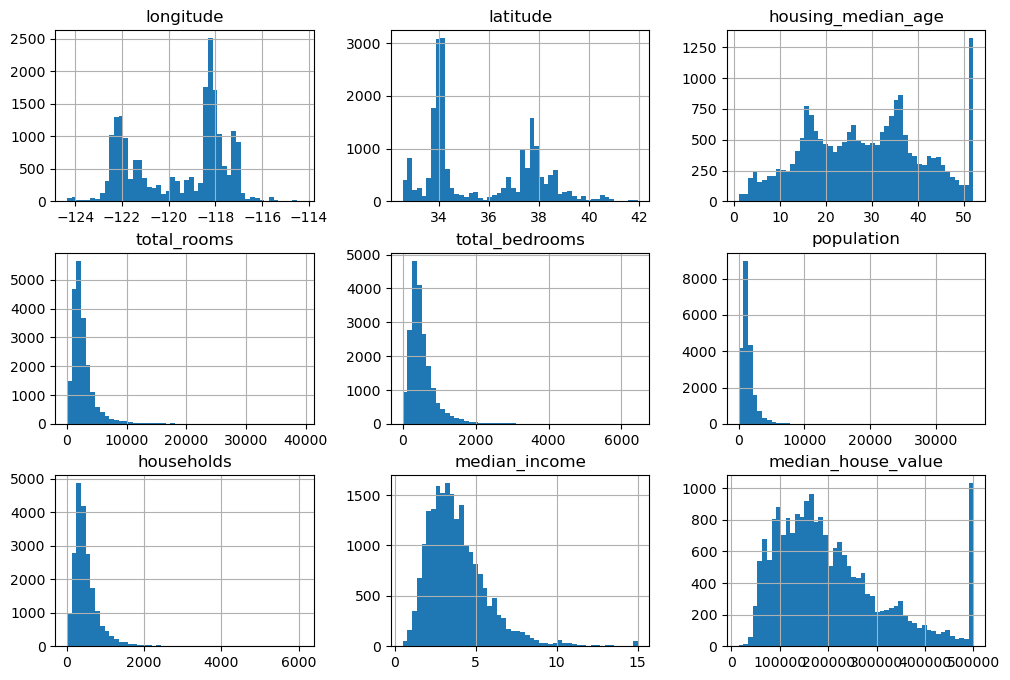

In [9]:
housing.hist(bins=50,figsize=(12,8))
plt.show()

In [10]:
housing['income_cat']=pd.cut(housing['median_income'],bins=[0,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])

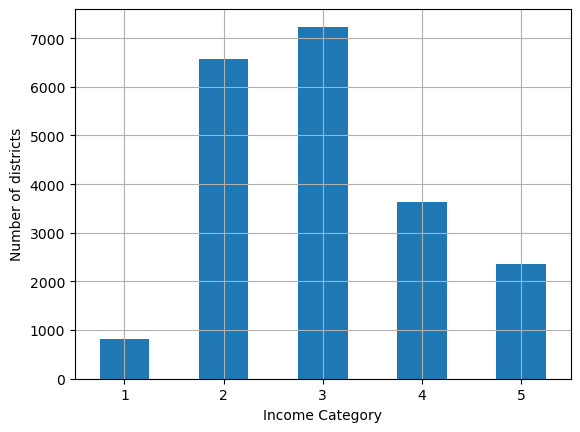

In [11]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel('Income Category')
plt.ylabel('Number of districts')
plt.show()

In [12]:
splitter=StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)
strat_splits=[]
for train_index, test_index in splitter.split(housing,housing['income_cat']):
    strat_train_set_n=housing.iloc[train_index]
    start_test_set_n=housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,start_test_set_n])

In [13]:
strat_train_set,strat_test_set=strat_splits[0]

In [14]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN,4
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND,2
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN,3
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN,3


In [15]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN,2
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND,2
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN,4
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY,4


In [16]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

C:\Users\ajay2\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY


C:\Users\ajay2\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


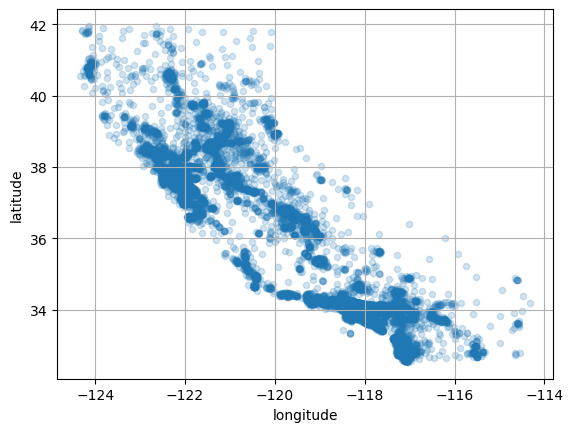

In [18]:
housing.plot(kind='scatter',x='longitude',y='latitude',grid=True, alpha=0.2)
plt.show()

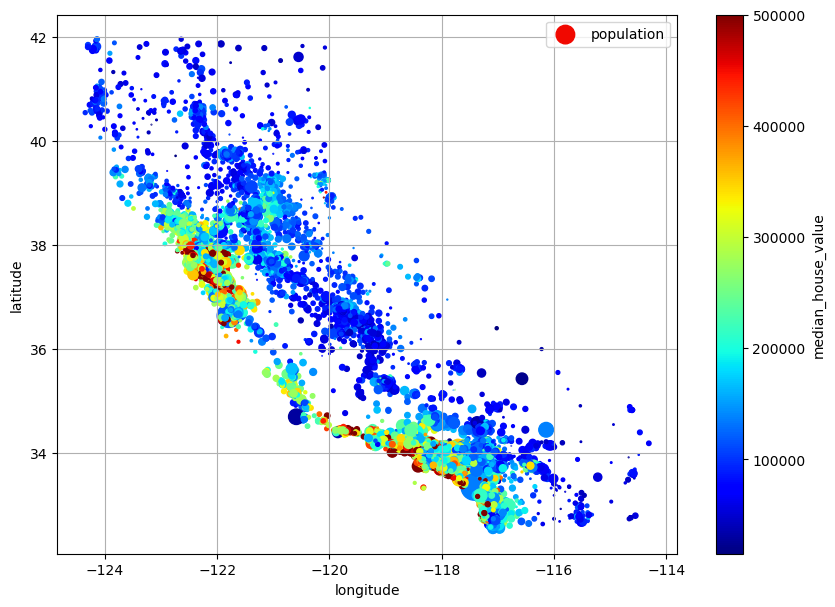

In [19]:
housing.plot(kind='scatter',x='longitude',y='latitude',grid=True, s=housing['population']/100 , label='population', c='median_house_value',cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

In [20]:
corr_matrix=housing.corr()

In [21]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [22]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [23]:
housing=strat_train_set.drop('median_house_value',axis=1)
housing_labels=strat_train_set['median_house_value'].copy()


In [24]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


# Feature engineering

# #Handling null values

In [25]:
imputer=SimpleImputer(strategy='median')

In [26]:
housing_num=housing.select_dtypes(include=[np.number])

In [27]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [28]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [29]:
x=imputer.transform(housing_num)

In [30]:
x

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

In [31]:
housing_tr=pd.DataFrame(x,columns=housing_num.columns, index=housing_num.index)

# #Handling categorical features

In [32]:
housing_cat=housing[['ocean_proximity']]

In [33]:
housing_cat

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
14207,<1H OCEAN
13105,INLAND
19301,NEAR OCEAN
19121,<1H OCEAN


In [34]:
ordinal_encoder=OrdinalEncoder()

In [35]:
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)

In [36]:
housing_cat_encoded

array([[3.],
       [0.],
       [1.],
       ...,
       [4.],
       [0.],
       [4.]])

In [37]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [38]:
cat_encoder=OneHotEncoder(sparse_output=False)

In [39]:
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)

In [40]:
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [41]:
housing_cat_1hot.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
cat_encoder.categories_

In [ ]:
cat_encoder.feature_names_in_

In [ ]:
cat_encoder.get_feature_names_out()

In [ ]:
housing_cat_1hot

# #Feature scaling and transformation

ML algorithms does not perform well if input numerical attributes have diffreent scales . The two comman ways are
min-max scaling and standardization
min-max scaling: (value-min)/(max-min) range of scaling (0,1) if want range(-1,1) set feature_range=(-1,1)
standardization:(value-mean)/standard deviation, no range restrication, works well compared to min-max scaling


# ##Minmax scaling

In [42]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler=MinMaxScaler(feature_range=(-1,1))

In [43]:
housing_num_min_max_scaled=min_max_scaler.fit_transform(housing_num)

In [44]:
min_max_scaler.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [45]:
min_max_scaler.get_feature_names_out

<bound method OneToOneFeatureMixin.get_feature_names_out of MinMaxScaler(feature_range=(-1, 1))>

In [46]:
pd.DataFrame(housing_num_min_max_scaled,columns=housing_num.columns,index=housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
14973,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
3785,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369
14689,0.468560,-0.744681,-0.372549,-0.787782,-0.726204,-0.774015,-0.709166,-0.756983
20507,0.257606,-0.740426,0.372549,-0.778015,-0.610243,-0.765796,-0.562815,-0.582171
...,...,...,...,...,...,...,...,...
14207,0.206897,-0.721277,0.568627,-0.886312,-0.808021,-0.885290,-0.805115,-0.419236
13105,0.022312,-0.197872,-0.137255,-0.850298,-0.809631,-0.826279,-0.801755,-0.714018
19301,0.478702,-0.991489,-0.529412,-0.800702,-0.750684,-0.655134,-0.716632,-0.508738
19121,0.206897,-0.678723,0.411765,-0.807773,-0.719117,-0.788738,-0.687512,-0.497166


In [47]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

In [48]:
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()
housing_num_std_scaled=std_scaler.fit_transform(housing_num)

In [49]:
pd.DataFrame(housing_num_std_scaled,columns=std_scaler.get_feature_names_out(),index=housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.136961,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.125165,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.556922,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.788136,0.273563,0.882868,0.145396


# ##Handling features with heavy tail distribution

FOr this type of features before scaling, for positive features apply square root or raise the feature to a power between 
0 to 1. If the feature has heavy long tail such as powerlaw distribution then replacing the feature with its logarithm may
help. 

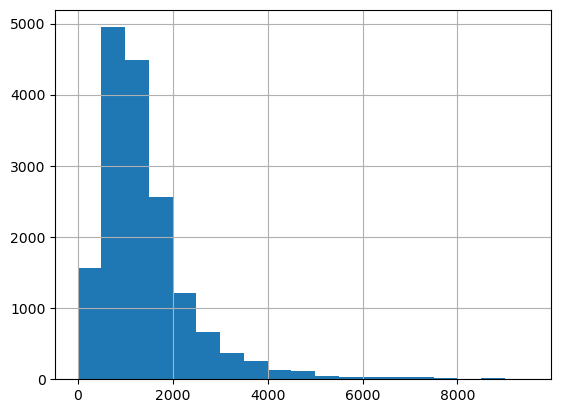

In [50]:
housing_num['population'].hist(bins=[i for i in range(0,10000,500)])
plt.show()

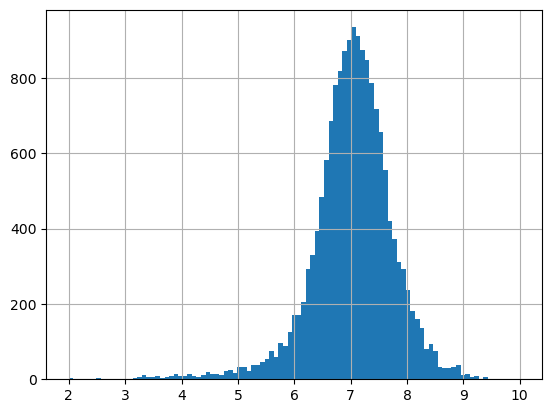

In [51]:
np.log(housing_num['population']).hist(bins=[i for i in np.linspace(2,10,100)])
plt.show()

# ##Multimodal features

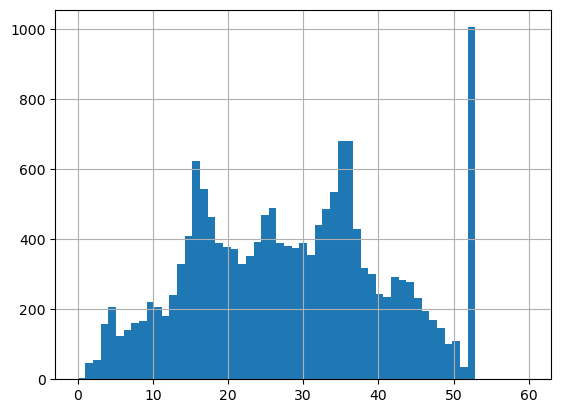

In [52]:
housing['housing_median_age'].hist(bins=[i for i in np.linspace(0,60,60)])
plt.show()

For this kind of features bucketizing and encodeing cetegories using OneHotEncodet. This aproach will allow the regression 
model to more easily to learn different rules for different ranges of this feature value. In the above example houses built 
35yrs ago have a peculiar style that fell out of fashion and hence they are cheaper than their age alone would suggest.

Another aproac to transforming multimodal distribution is to add a feature for each of the modes(for atleast the main modes(peaks))
and representing the similarity between the housing median age and that particular mode. This similarity measure is typically
computed using a radial basis function (RBF)- any function that depends only on the distance between the input value and a 
fixed point. Most commonly used RBF is Gausian RBF, whose output value decays exponentially as the input value moves away 
from the fixed point. Here housing age mode 35 is given by exp(-r(x-35)**2) where r is hyper parameter which determines 
how fast similarity measure decays as x moves away from 35.

In [53]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35=rbf_kernel(housing[['housing_median_age']],[[35]],gamma=0.1)

# Transforming of target values

As like input features we need to transform target features as well but to get final target value we need to apply
inverse transformation back. But luckily in sklearn's transformers have an inverse_transform() method as well. 

In [54]:
from sklearn.linear_model import LinearRegression
target_scaler=StandardScaler()
scaled_labels=target_scaler.fit_transform(housing_labels.to_frame())

model=LinearRegression()
model.fit(housing[['median_income']],scaled_labels)
some_new_data=housing[['median_income']].iloc[:5]   #Assume this to be new data
scaled_predictions=model.predict(some_new_data)
predictions=target_scaler.inverse_transform(scaled_predictions)

This works but simple way to do is using TransformedTargetRegressor.We just need to construct it, giving it the regression
model and the label transformer, then fit it on the training set, using the original unscaled labels. It will automatically
use the transformer to scale the lablels and train the regression model on the resulting scaled lables. Then when we want to
make prediction it will call the regression model's predict() method and use the scaler's inverse_transform() method to
produce the prediction

In [55]:
from sklearn.compose import TransformedTargetRegressor

model=TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[['median_income']],housing_labels)
predictions=model.predict(some_new_data)

# Custom Transformers

Althous sklearn provides many usefull transormers, sometimes we need to write code for custom transformers . 
eg: for heavily tailed distributions we replace feature with its logarithm. Lets write this 

In [56]:
from sklearn.preprocessing import FunctionTransformer

In [57]:
log_transformer=FunctionTransformer(np.log,inverse_func=np.exp,feature_names_out='one-to-one')
log_pop=log_transformer.transform(housing[['population']])

In [58]:
log_transformer.get_feature_names_out()

array(None, dtype=object)

In [59]:
log_transformer.inverse_func

<ufunc 'exp'>

In [60]:
log_transformer.func

<ufunc 'log'>

The inverse_func argument is optional. It lets specity a inverse transfor function, eg:if we plan to use your transformer 
in a TransformedTargetRegressor.

FunctionTransformer is very handy, but what if would like our transformer to be trainable, learning some parameters in the 
fit() method and using them later in the tranform() method? For this, we need to write a custom class. Sklearn relies on 
duck typing, so this class does not have to inherit from any particular base class. All it needs is three methods:fit()
(which returns self), transform() and fit_transform().

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardSCalerClone(BaseEstimator, TransformerMixin):
    def __init__(self,with_mean=True):
        self.with_mean=with_mean
    def fit(self,X,y=None):  #y is required even though we don't us it
        X=check_array(X)      #checks that X is an arrary with finite float values
        self.mean_=X.mean(axis=0)
        self.n_features_in_=X.shape[1] #every estimator stores this in fit()
        return self                    #always return self!
    def transform(self,X):
        check_is_fitted(self)     #looks for learned attributes(with trailing_)
        X=check_array(x)
        assert self.n_features_in_==X.shape[1]
        if self.with_mean:
            X=X-self.mean_
        return X/self.scale_

Scikit-learn pipelines require the fit() method to have two arguments X and y, which is why we need the y=None argument
even though we dont use y
scikit-Learn estimators set n_features_in_ in the fit() method and they ensure that the data passed to transform() or 
preditct() has this no of features
All transformers should provide a get_features_names_out() method , an inverse_transform() method when their 
transformation can be reversed.


In [62]:
class ClusterSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,n_clusters=10,gamma=1.0,random_state=None):
        self.n_clusters=n_clusters
        self.gamma=gamma
        self.random_state=random_state
    def fit(self,x,y=None,sample_weight=None):
        self.kmeans_=KMeans()
        self.kmeans_.fit(x,sample_weight=sample_weight)
        return self
    def transform(self,x):
        return rbf_kernel(x,self.kmeans_.cluster_centers_,gamma=self.gamma)
    def get_feature_names_out(self,names=None):
        return [f'cluster {i} similarity' for i in range(self.n_clusters)]
        

# ##Trasformation Pipelines

In [63]:
from sklearn.pipeline import Pipeline

num_pipeline=Pipeline([('impute', SimpleImputer(strategy='median')),('standardize', StandardScaler())])

set_config (display='diagram') in sklearn is usefull to visualize interactive diagrams about created pipelines.

In [64]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

# Method2

In [65]:
from sklearn.pipeline import make_pipeline
num_pipeline=make_pipeline(SimpleImputer(strategy='median',add_indicator=True),StandardScaler())

In [66]:
num_pipeline

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('standardscaler', StandardScaler())])

when you call the pipline's fit() method, it calls fit_transform() sequentially on all the transformers, passing output of
each call as the parameter to the next call until it reaches the final estimator, for which it calls just fit() method.
The pipeline exposes the same methods as the final estimator. In this example the last estimator is a StandardScaler, which
 is a transformer, so the pipeline also acts like a transformer. If you call the pipeline's transform() method, it will
sequentially apply all the transformations to the data. If the last estimator were predictor instead of a transformer, then 
pipeline would have a predict() method rather than a transform() method. Calling it would sequentially apply all the 
transformations to the data and pass the result to the predictor's predict() method.

In [67]:
housing_num_prepared=num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94, -0.1 ],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17, -0.1 ]])

In [68]:
num_pipeline.inverse_transform(housing_num_prepared)

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

In [69]:
df_housing_num_prepared=pd.DataFrame(housing_num_prepared,columns=num_pipeline.get_feature_names_out(),index=housing_num.index)

Pipelines support indexing;eg:pipeline[1] returns second estimator in the pipeline, and pipeline[:-1] returns a  pipeline object containing all but the last estimator.
We can also access the estimators via the steps attribute which is a list of names/estimators pairs, or via the named_steps 
dictionary attribute which maps the names to the estimators

In [70]:
num_pipeline.named_steps

{'simpleimputer': SimpleImputer(add_indicator=True, strategy='median'),
 'standardscaler': StandardScaler()}

In [71]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(add_indicator=True, strategy='median')),
 ('standardscaler', StandardScaler())]

# Column Transformer

It would be more convenient to have a single transformer capable of handling all columns, applying the appropriate
transformations to each column. For this we use  class called ColumnTransformer. It can apply num_pipeline for num attributes
and cat_pipeline for categorical attributes at a time

# method1

In [72]:
num_attribs=['longitude','lattitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
cat_attribs=['ocean_proximity']
cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
preprocessing=ColumnTransformer([('num',num_pipeline,num_attribs),('cat',cat_pipeline,cat_attribs)])

# method2

In [73]:
preprocessing=make_column_transformer((num_pipeline,make_column_selector(dtype_include=np.number)),(cat_pipeline,make_column_selector(dtype_include=object)))

In [74]:
housing_prepared=preprocessing.fit_transform(housing)

In [75]:
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

Instead of using a transformer, we can specify the string 'drop' of we want columns to be dropped, or we can specify
'passthrough' if we want the columns to be left untouched. By default, the remaiing columns (ie., the ones that were not 
listed) will be dropped, but we can set the remaintder hyperparameter to any trasformer if we want to handle these 
differently

In [76]:
def column_ratio(x):
    return x[:,[0]]/x[:,[1]]
def ratio_name(functiontransformer,feature_names_in):
    return ['ratio']
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio,
        feature_names_out=ratio_name),StandardScaler())
log_pipeline=make_pipeline(SimpleImputer(strategy='median'),
                           FunctionTransformer(np.log,feature_names_out='one-to-one'),
                          StandardScaler())
cluster_simil=ClusterSimilarity(n_clusters=10,gamma=1,random_state=42)
default_num_pipeline=make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
preprocessing=ColumnTransformer([('bedrooms',ratio_pipeline(),['total_bedrooms','total_rooms']),
                                 ('rooms_per_house',ratio_pipeline(),['total_rooms','households']),
                                ('people_per_house',ratio_pipeline(),['population','households']),
                                ('log',log_pipeline,['total_bedrooms','total_rooms','population','households','median_income']),
                                ('geo',cluster_simil,['latitude','longitude']),
                                ('cat',cat_pipeline,make_column_selector(dtype_include=object)),
                                ],remainder=default_num_pipeline)

In [77]:
housing_prepared=preprocessing.fit_transform(housing)

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [78]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                                                      func=<function column_r...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo',
                                 ClusterSimilarity(gamma=1, random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2815C73D0>)])

In [79]:
preprocessing.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                                                      func=<function column_r...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                        

In [80]:
preprocessing.transformers

[('bedrooms',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                       func=<function column_ratio at 0x000001F282691040>)),
                  ('standardscaler', StandardScaler())]),
  ['total_bedrooms', 'total_rooms']),
 ('rooms_per_house',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                       func=<function column_ratio at 0x000001F282691040>)),
                  ('standardscaler', StandardScaler())]),
  ['total_rooms', 'households']),
 ('people_per_house',
  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                  ('functiontransformer',
                   Functio

In [81]:
preprocessing.named_transformers_

{'bedrooms': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('functiontransformer',
                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                      func=<function column_ratio at 0x000001F282691040>)),
                 ('standardscaler', StandardScaler())]),
 'rooms_per_house': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('functiontransformer',
                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                      func=<function column_ratio at 0x000001F282691040>)),
                 ('standardscaler', StandardScaler())]),
 'people_per_house': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('functiontransformer',
                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
               

In [82]:
preprocessing.transformers[0]

('bedrooms',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('functiontransformer',
                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                      func=<function column_ratio at 0x000001F282691040>)),
                 ('standardscaler', StandardScaler())]),
 ['total_bedrooms', 'total_rooms'])

In [83]:
housing_prepared.shape

(16512, 22)

In [84]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__cluster 0 similarity',
       'geo__cluster 1 similarity', 'geo__cluster 2 similarity',
       'geo__cluster 3 similarity', 'geo__cluster 4 similarity',
       'geo__cluster 5 similarity', 'geo__cluster 6 similarity',
       'geo__cluster 7 similarity', 'geo__cluster 8 similarity',
       'geo__cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [85]:
housing_prepared

array([[ 1.84662439, -0.86602737, -0.33020372, ...,  1.        ,
         0.        ,  1.86111875],
       [-0.5081207 ,  0.0245495 , -0.25361631, ...,  0.        ,
         0.        ,  0.90762971],
       [-0.20215476, -0.04119332, -0.05104091, ...,  0.        ,
         0.        ,  0.35142777],
       ...,
       [-0.24249175, -0.10998748,  0.15854151, ...,  0.        ,
         1.        , -1.23772062],
       [ 0.25977479, -0.36093745, -0.21033248, ...,  0.        ,
         0.        ,  0.66925745],
       [ 3.61270996, -1.32397227,  0.04958379, ...,  0.        ,
         1.        ,  1.22545939]])

# Select and Training a model

In [86]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F28492FE50>,
                                                                      func=<function column_r...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo',
                                 ClusterSimilarity(gamma=1, random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2815C73D0>)])

In [87]:
lin_reg=make_pipeline(preprocessing,LinearRegression())

In [88]:
lin_reg.fit(housing,housing_labels)

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2815C73D0>)])),
                ('linearregression', LinearRegression())])

In [89]:
housing_predictions=lin_reg.predict(housing)

In [90]:
housing_predictions[:5].round(2)

array([247480.82, 373031.21, 136908.04,  93098.51, 326658.25])

In [91]:
housing_labels[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [92]:
lin_rmse=mean_squared_error(housing_predictions,housing_labels,squared=False)

In [93]:
lin_rmse

68924.40914371569

In [238]:
tree_reg=make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42))

In [239]:
tree_reg.fit(housing,housing_labels)

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002435ADB29A0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [240]:
housing_predictions=tree_reg.predict(housing)

In [241]:
housing_predictions[:5].round(2)

array([458300., 483800., 101700.,  96100., 361800.])

In [242]:
tree_rmse=mean_squared_error(housing_predictions,housing_labels,squared=False)

In [243]:
tree_rmse

0.0

Decision tree reg clearly overfitting the model. To evaluate any model use train_test_split() with cross validation.
Using the following code we split data into 10 non overlapping subsets called folds, then trains and evaluates the decision
tree model 10 times, picking different fold for evaluation every time and using the other 9 folds for training.

In [246]:
tree_rmses=-cross_val_score(tree_reg,housing,housing_labels,cv=10,scoring="neg_root_mean_squared_error")

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [248]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     65242.114769
std       2575.398294
min      61096.180969
25%      63072.141253
50%      65867.457337
75%      66942.759063
max      68569.570158
dtype: float64

In [249]:
forest_reg=make_pipeline(preprocessing,RandomForestRegressor(random_state=42))

In [250]:
forest_rmses=-cross_val_score(forest_reg,housing,housing_labels,scoring="neg_root_mean_squared_error",cv=3)

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [252]:
pd.Series(forest_rmses).describe()

count        3.000000
mean     47948.376192
std        303.948363
min      47738.790653
25%      47774.078173
50%      47809.365693
75%      48053.168961
max      48296.972229
dtype: float64

This seems to be much better model, but this is not enough, we have to shortlist 3 to 5 better models like svr,deep learning etc and then have to regularize to reduce overfitting. This is done using the hyper parameter tuning. Rather than 
doing this manually we use two methods.

# Grid serch cv

In [94]:
full_pipeline=Pipeline([("preprocessing",preprocessing),("random_forest",RandomForestRegressor(random_state=42))])

In [102]:
param_grid=[{'preprocessing__geo__n_clusters':[5,8,10],
            'random_forest__max_features':[4,6,8]},
            {'preprocessing__geo__n_clusters':[10,15],
            'random_forest__max_features':[6,8,10]}
           ]

NOtice that we can refer to any parameter of any estimator in a pipeline, even if this estimator is deep inside several pipelines and column transormers. For eg. when sklearn sees 'preprocessing__geo__n_clusters', it splits the string at the double underscores, then it looks for estimator named 'preprocessing' in the pipeline and finds the preprocessing Column Transformer. Next it looks for a trasformer named 'geo' inside thi Column Transformer and finds the Cluster Similarity tranformer we used on the lattitude and logitude attributes. Then it finds this transformer n_clusters hyperparameter. Similarly, random_forest__max_features refer to the max_features hyperparameter of the estimator named 'rodaom_forest', which is of course the RandomForest model.

In [103]:
grid_search=GridSearchCV(full_pipeline,param_grid,cv=3,scoring='neg_root_mean_squared_error')

In [104]:
grid_search.fit(housing,housing_labels)

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2815C73D0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [106]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [111]:
cv_res=pd.DataFrame(grid_search.cv_results_,columns=['param_preprocessing__geo__n_clusters','param_random_forest__max_features','split0_test_score','mean_test_score','rank_test_score'])

In [110]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [112]:
cv_res.sort_values(by='rank_test_score',inplace=True)

In [113]:
cv_res

,param_preprocessing__geo__n_clusters,param_random_forest__max_features,split0_test_score,mean_test_score,rank_test_score
12,15,6,-45078.812547,-45405.437745,1
9,10,6,-44969.308147,-45541.567840,2
4,8,6,-45225.526992,-45581.089530,3
0,5,4,-45151.502797,-45628.756684,4
1,5,6,-45212.294081,-45635.107934,5
3,8,4,-45328.282023,-45662.182231,6
7,10,6,-45321.398171,-45672.067802,7
6,10,4,-45233.840291,-45749.229800,8
13,15,8,-45377.332950,-45761.451091,9
2,5,8,-45372.369893,-45806.301383,10


# Randmized Search

If some of the hyperparameters are continuous and if we let randomized search run for, say, 1000 iterations, then it will explore 1000 differnet values for each of these hyperparameters. where as gridsearch would only explore the few values listed for each one.

In [124]:
param_distribs={'preprocessing__geo__n_clusters':randint(low=3,high=50),
               'random_forest__max_features':randint(low=2,high=20)}

In [125]:
rnd_search=RandomizedSearchCV(
    full_pipeline,param_distributions=param_distribs,n_iter=10,cv=3,scoring='neg_root_mean_squared_error',random_state=42)

In [126]:
rnd_search.fit(housing,housing_labels)

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

C:\Users\ajay2\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F28B3BD2B0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F28B3A92E0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [127]:
rnd_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001F...
                                                                    n_clusters=13,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F288655A00>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=5, random_state=42))])

In [128]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 13, 'random_forest__max_features': 5}

In [129]:
final_model=rnd_search.best_estimator_

In [2]:
feature_importances=final_model['random_forest'].feature_importances_

NameError: name 'final_model' is not defined

In [133]:
feature_importances.round(2)

array([0.09, 0.06, 0.08, 0.01, 0.02, 0.02, 0.01, 0.26, 0.04, 0.04, 0.03,
       0.04, 0.02, 0.04, 0.07, 0.03, 0.01, 0.11, 0.  , 0.  , 0.01, 0.03])

In [1]:
sorted(zip(feature_importances,final_model['preprocessing'].get_feature_names_out()))

NameError: name 'feature_importances' is not defined